This notebook presents statistics of the book data integration.


## Setup


In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

## Load Link Stats

We compute dataset linking statistics as `gender-stats.csv` as part of the integration.  Let's load those:


In [2]:
link_stats = pd.read_csv('book-links/gender-stats.csv')
link_stats.head()

,dataset,gender,n_books,n_actions
0,LOC-MDS,ambiguous,73989,NaN
1,LOC-MDS,unknown,1084460,NaN
2,LOC-MDS,no-book-author,600216,NaN
3,LOC-MDS,male,2424008,NaN
4,LOC-MDS,female,743105,NaN


Now let's define variables for our variou codes. We are first going to define our gender codes.  We'll start with the resolved codes:


In [3]:
link_codes = ['female', 'male', 'ambiguous', 'unknown']

We want the unlink codes in order, so the last is the first link failure:


In [4]:
unlink_codes = ['no-author-rec', 'no-book-author', 'no-book']

In [5]:
all_codes = link_codes + unlink_codes

## Processing Statistics

Now we'll pivot each of our count columns into a table for easier reference.


In [6]:
book_counts = link_stats.pivot('dataset', 'gender', 'n_books')
book_counts = book_counts.reindex(columns=all_codes)
book_counts.assign(total=book_counts.sum(axis=1))

/var/folders/rp/hd85d1b94pd2cfs8q8h9fjx52t1n0n/T/ipykernel_4655/233082166.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  book_counts = link_stats.pivot('dataset', 'gender', 'n_books')


gender,female,male,ambiguous,unknown,no-author-rec,no-book-author,no-book,total
dataset,,,,,,,,
AZ14,248863.0,550877.0,24064.0,239915.0,155511.0,167948.0,870268.0,2257446.0
AZ18,318004.0,670899.0,27977.0,300300.0,239917.0,152438.0,1144899.0,2854434.0
BX-E,40256.0,58484.0,5596.0,15281.0,5692.0,5428.0,17481.0,148218.0
BX-I,71441.0,102756.0,9528.0,31440.0,11562.0,10861.0,35009.0,272597.0
GR-E,225840.0,334136.0,18516.0,106501.0,60515.0,738282.0,NaN,1483790.0
GR-I,228142.0,338411.0,18709.0,108333.0,61601.0,750118.0,NaN,1505314.0
LOC-MDS,743105.0,2424008.0,73989.0,1084460.0,306291.0,600216.0,NaN,5232069.0


In [7]:
act_counts = link_stats.pivot('dataset', 'gender', 'n_actions')
act_counts = act_counts.reindex(columns=all_codes)
act_counts.drop(index='LOC-MDS', inplace=True)
act_counts

/var/folders/rp/hd85d1b94pd2cfs8q8h9fjx52t1n0n/T/ipykernel_4655/71450322.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  act_counts = link_stats.pivot('dataset', 'gender', 'n_actions')


gender,female,male,ambiguous,unknown,no-author-rec,no-book-author,no-book
dataset,,,,,,,
AZ14,4977284.0,7105363.0,849025.0,2157265.0,1100127.0,2359170.0,3879190.0
AZ18,12377052.0,15603235.0,1844630.0,4692726.0,3312340.0,2820794.0,10008921.0
BX-E,142252.0,183945.0,41768.0,24554.0,7130.0,7234.0,19920.0
BX-I,401483.0,468156.0,104008.0,69361.0,18597.0,18882.0,47275.0
GR-E,36335167.0,33249747.0,13230835.0,3570086.0,1039410.0,11168052.0,NaN
GR-I,82889862.0,69977512.0,22091068.0,10242726.0,3545964.0,29784689.0,NaN


We're going to want to compute versions of this table as fractions, e.g. the fraction of books that are written by women.  We will use the following helper function:


In [8]:
def fractionalize(data, columns, unlinked=None):
    fracs = data[columns]
    fracs.columns = fracs.columns.astype('str')
    if unlinked:
        fracs = fracs.assign(unlinked=data[unlinked].sum(axis=1))
    totals = fracs.sum(axis=1)
    return fracs.divide(totals, axis=0)

And a helper function for plotting bar charts:


In [9]:
def plot_bars(fracs, ax=None, cmap=mpl.cm.Dark2):
    if ax is None:
        ax = plt.gca()
    size = 0.5
    ind = np.arange(len(fracs))
    start = pd.Series(0, index=fracs.index)
    for i, col in enumerate(fracs.columns):
        vals = fracs.iloc[:, i]
        rects = ax.barh(ind, vals, size, left=start, label=col, color=cmap(i))
        for j, rec in enumerate(rects):
            if vals.iloc[j] < 0.1 or np.isnan(vals.iloc[j]): continue
            y = rec.get_y() + rec.get_height() / 2
            x = start.iloc[j] + vals.iloc[j] / 2
            ax.annotate('{:.1f}%'.format(vals.iloc[j] * 100),
                        xy=(x,y), ha='center', va='center', color='white',
                        fontweight='bold')
        start += vals.fillna(0)
    ax.set_xlabel('Fraction of Books')
    ax.set_ylabel('Data Set')
    ax.set_yticks(ind)
    ax.set_yticklabels(fracs.index)
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

## Resolution of Books

What fraction of *unique books* are resolved from each source?


In [10]:
fractionalize(book_counts, link_codes + unlink_codes)

gender,female,male,ambiguous,unknown,no-author-rec,no-book-author,no-book
dataset,,,,,,,
AZ14,0.110241,0.244027,0.010660,0.106277,0.068888,0.074397,0.385510
AZ18,0.111407,0.235037,0.009801,0.105205,0.084051,0.053404,0.401095
BX-E,0.271600,0.394581,0.037755,0.103098,0.038403,0.036622,0.117941
BX-I,0.262076,0.376952,0.034953,0.115335,0.042414,0.039843,0.128428
GR-E,0.152205,0.225191,0.012479,0.071776,0.040784,0.497565,NaN
GR-I,0.151558,0.224811,0.012429,0.071967,0.040922,0.498313,NaN
LOC-MDS,0.142029,0.463298,0.014141,0.207272,0.058541,0.114719,NaN


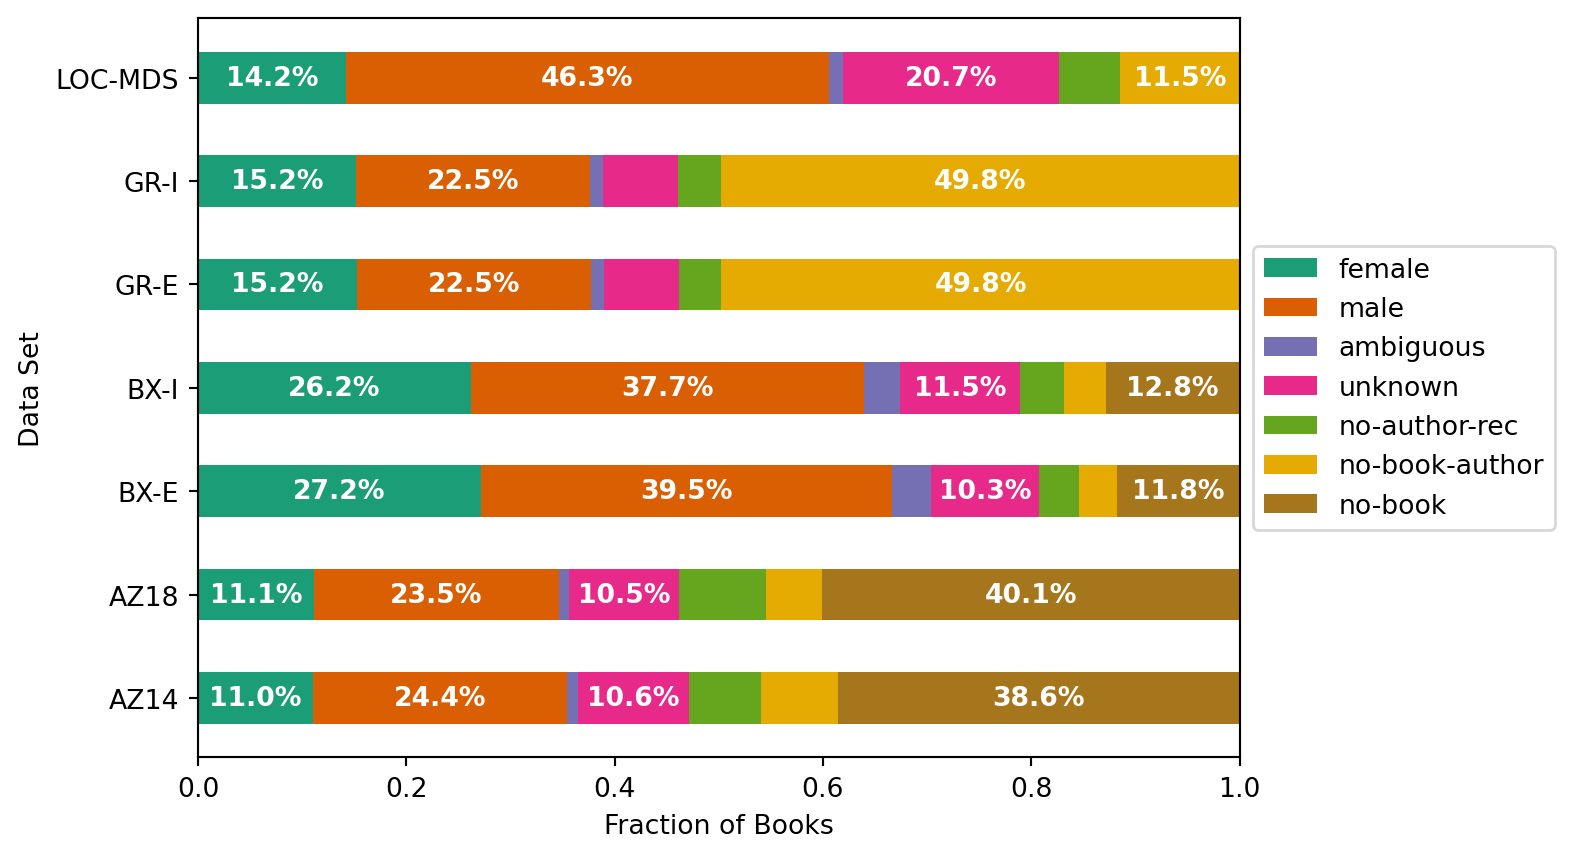

In [11]:
plot_bars(fractionalize(book_counts, link_codes + unlink_codes))

In [12]:
fractionalize(book_counts, link_codes, unlink_codes)

gender,female,male,ambiguous,unknown,unlinked
dataset,,,,,
AZ14,0.110241,0.244027,0.010660,0.106277,0.528795
AZ18,0.111407,0.235037,0.009801,0.105205,0.538549
BX-E,0.271600,0.394581,0.037755,0.103098,0.192966
BX-I,0.262076,0.376952,0.034953,0.115335,0.210685
GR-E,0.152205,0.225191,0.012479,0.071776,0.538349
GR-I,0.151558,0.224811,0.012429,0.071967,0.539236
LOC-MDS,0.142029,0.463298,0.014141,0.207272,0.173260


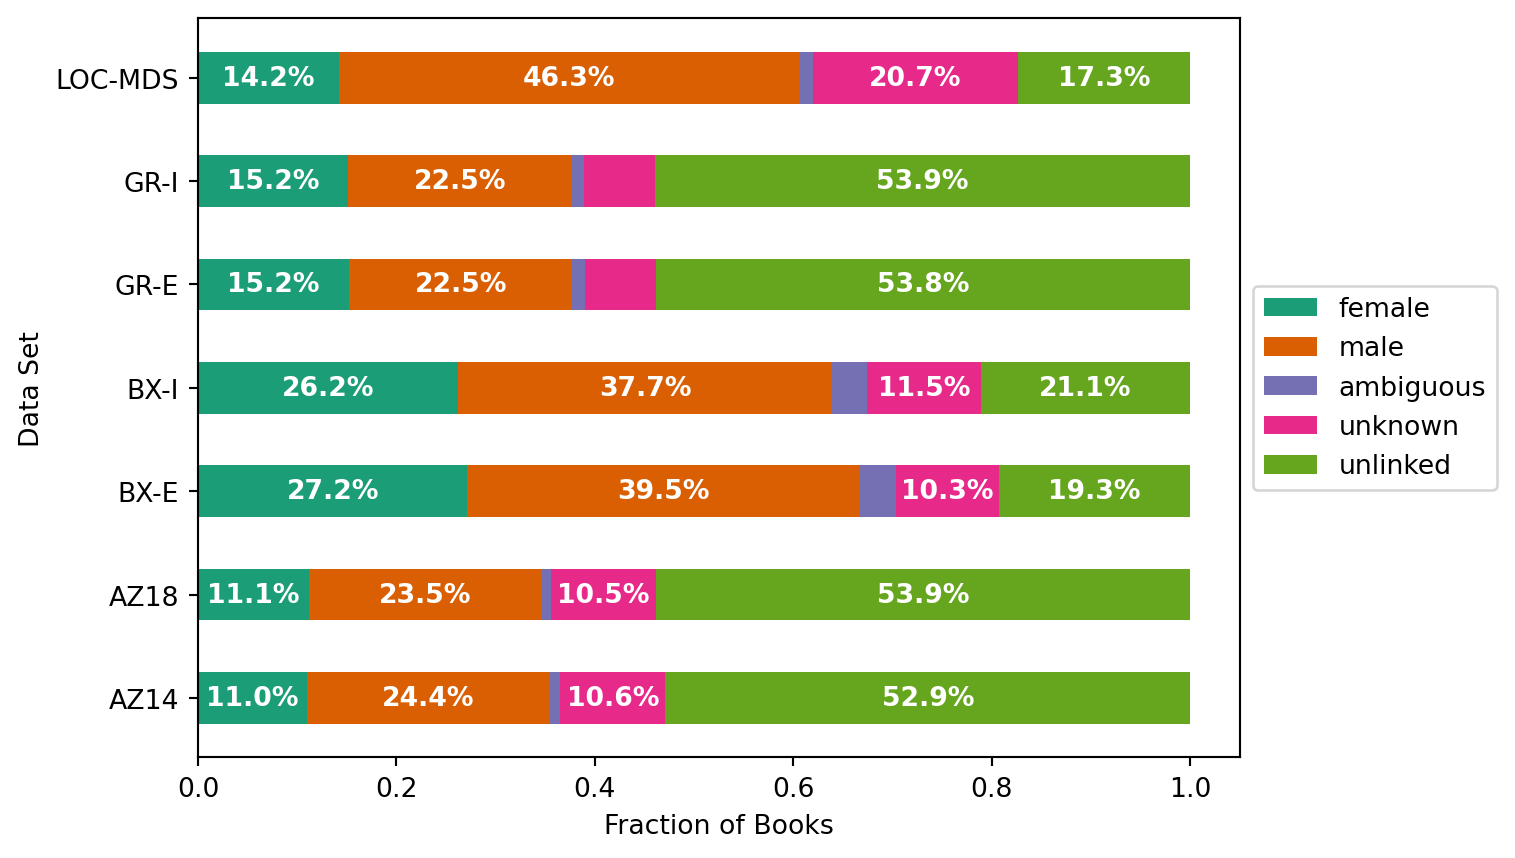

In [13]:
plot_bars(fractionalize(book_counts, link_codes, unlink_codes))

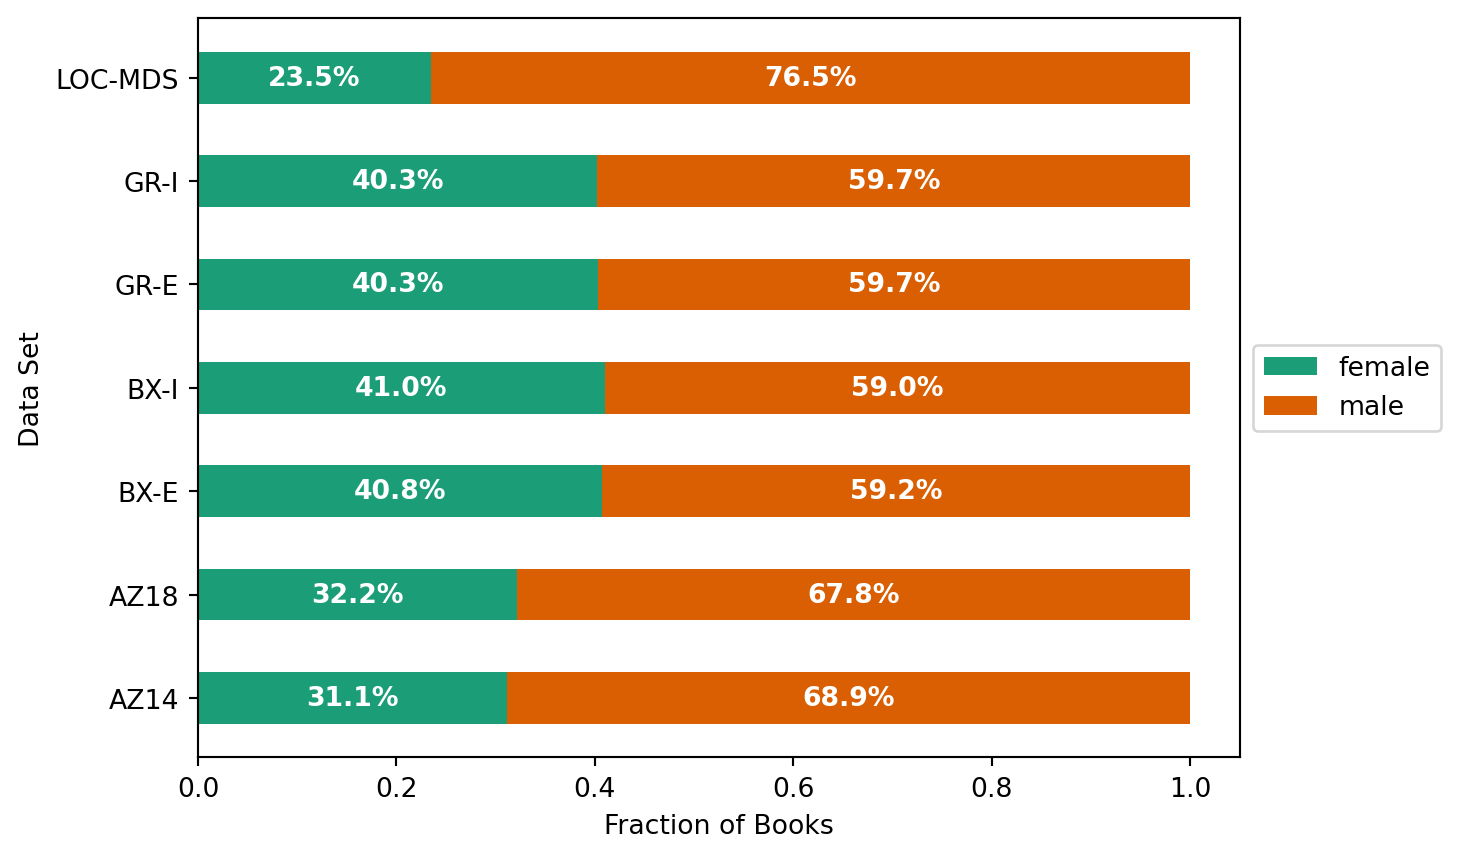

In [14]:
plot_bars(fractionalize(book_counts, ['female', 'male']))

## Resolution of Ratings

What fraction of *rating actions* have each resolution result?


In [15]:
fractionalize(act_counts, link_codes + unlink_codes)

gender,female,male,ambiguous,unknown,no-author-rec,no-book-author,no-book
dataset,,,,,,,
AZ14,0.221928,0.316816,0.037857,0.096189,0.049053,0.105191,0.172966
AZ18,0.244318,0.308001,0.036412,0.092632,0.065384,0.055681,0.197572
BX-E,0.333297,0.430983,0.097862,0.057530,0.016706,0.016949,0.046673
BX-I,0.356000,0.415120,0.092225,0.061503,0.016490,0.016743,0.041919
GR-E,0.368536,0.337241,0.134196,0.036210,0.010542,0.113274,NaN
GR-I,0.379303,0.320217,0.101089,0.046871,0.016226,0.136295,NaN


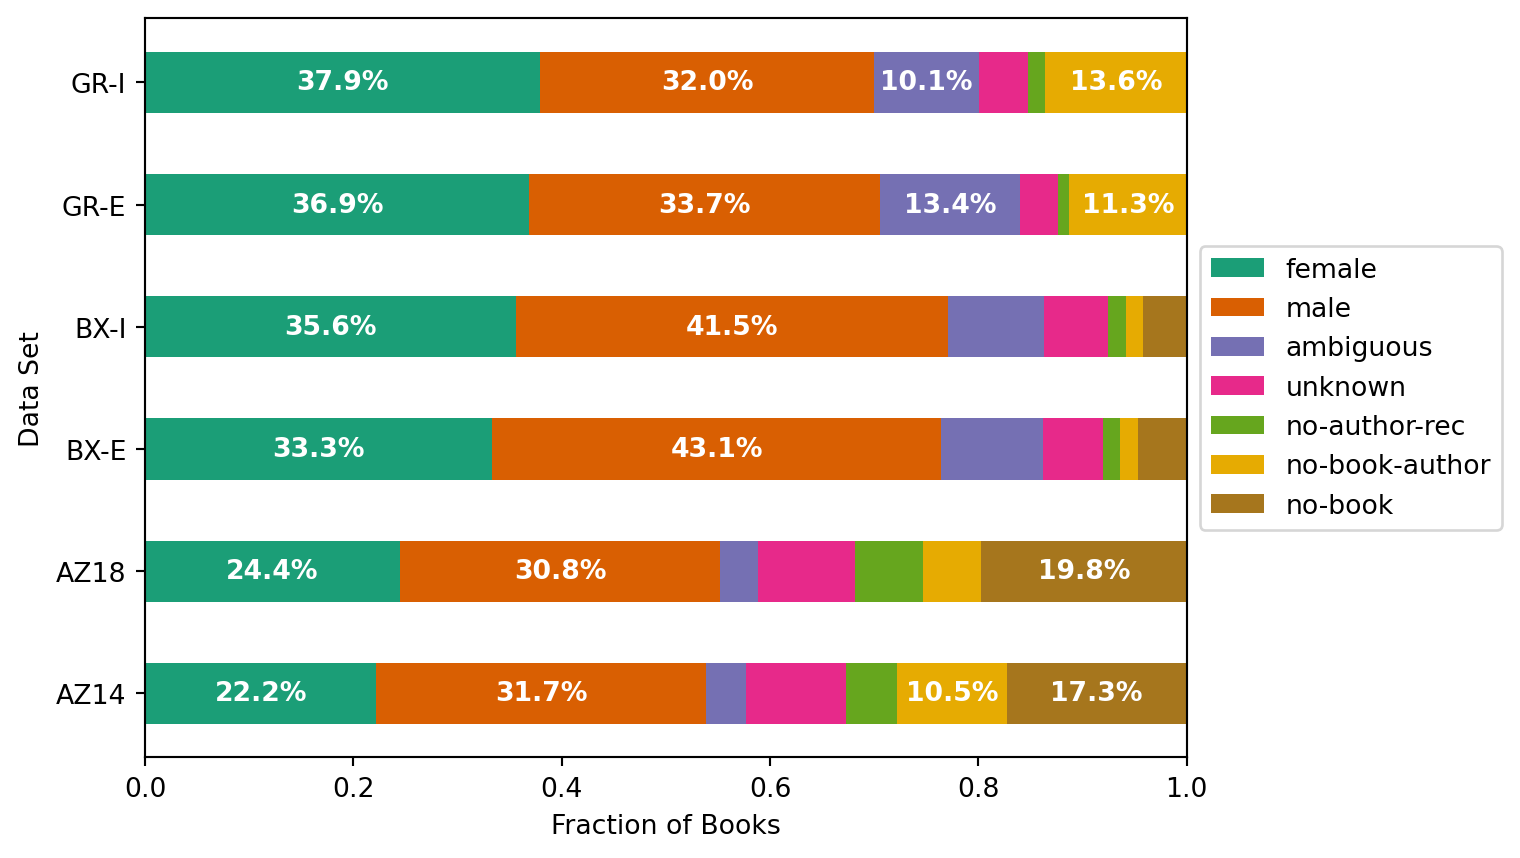

In [16]:
plot_bars(fractionalize(act_counts, link_codes + unlink_codes))

In [17]:
fractionalize(act_counts, link_codes, unlink_codes)

gender,female,male,ambiguous,unknown,unlinked
dataset,,,,,
AZ14,0.221928,0.316816,0.037857,0.096189,0.327210
AZ18,0.244318,0.308001,0.036412,0.092632,0.318637
BX-E,0.333297,0.430983,0.097862,0.057530,0.080327
BX-I,0.356000,0.415120,0.092225,0.061503,0.075152
GR-E,0.368536,0.337241,0.134196,0.036210,0.123816
GR-I,0.379303,0.320217,0.101089,0.046871,0.152521


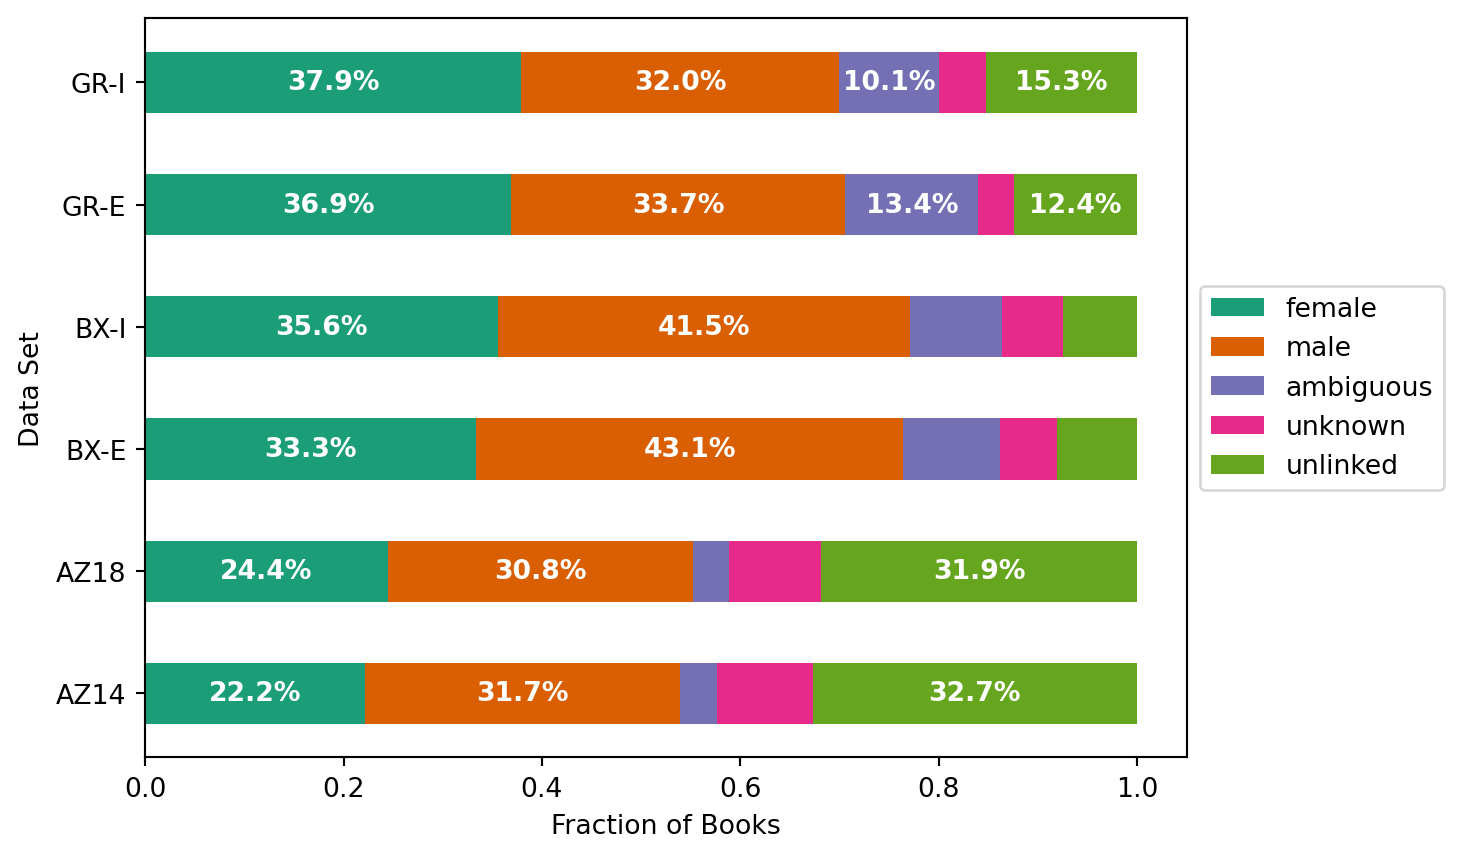

In [18]:
plot_bars(fractionalize(act_counts, link_codes, unlink_codes))

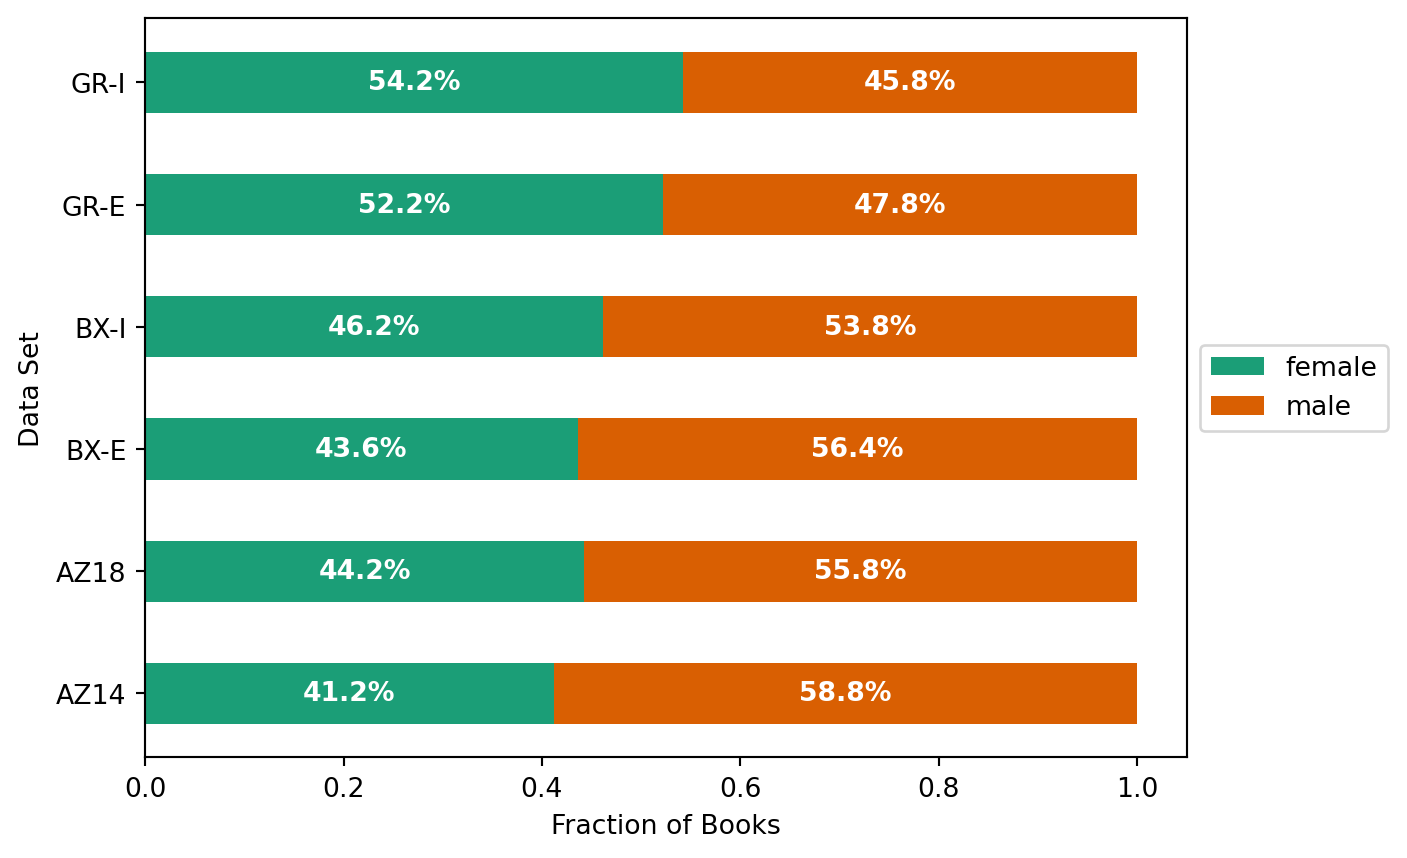

In [19]:
plot_bars(fractionalize(act_counts, ['female', 'male']))

## Metrics

Finally, we're going to write coverage metrics.


In [20]:
book_tots = book_counts.sum(axis=1)
book_link = book_counts['male'] + book_counts['female'] + book_counts['ambiguous']
book_cover = book_link / book_tots
book_cover

dataset
AZ14       0.364927
AZ18       0.356246
BX-E       0.703936
BX-I       0.673980
GR-E       0.389875
GR-I       0.388797
LOC-MDS    0.619469
dtype: float64

In [21]:
book_cover.to_json('book-coverage.json')